# **--- Estimate the Functional Connectivity (FC) ---**
---

In this tutorial, we're going to go through the following points :
1. Estimation of the undirected static and dynamic FC
1. Estimation of the directed static and dynamic FC

In [21]:
import os

import numpy as np
import scipy
import xarray as xr
import pandas as pd

from frites.conn import (conn_dfc, conn_covgc, conn_reshape_undirected,
                         conn_reshape_directed, define_windows, plot_windows,
                         conn_ravel_directed)

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed

plt.style.use('seaborn-dark')
plt.style.use('seaborn-poster')

%load_ext autoreload
%autoreload 2

---
# **--- ROOT PATH ---**

<div class="alert alert-info"><p>

Define the path to where the data are located !
</p></div>

In [22]:
ROOT = '/run/media/etienne/DATA/Toolbox/BraiNets/CookingFrites/dataset/'

---
# **0 - Functions**

In [23]:
###############################################################################
###############################################################################
#                 Load the data of a single subject
###############################################################################
###############################################################################

def load_ss(subject_nb):
    """Load the data of a single subject.
    
    Parameters
    ----------
    subject_nb : int
        Subject number [0, 12]
    
    Returns
    -------
    hga : xarray.DataArray
        Xarray containing the high-gamma activity
    anat : pandas.DataFrame
        Table containing the anatomical informations
    beh : pandas.DataFrame
        Table containing the behavioral informations
    """
    # load the high-gamma activity
    file_hga = os.path.join(ROOT, 'hga', f'hga_s-{subject_nb}.nc')
    hga = xr.load_dataarray(file_hga)

    # load the name of the brain regions
    file_anat = os.path.join(ROOT, 'anat', f'anat_s-{subject_nb}.xlsx')
    anat = pd.read_excel(file_anat)

    # load the behavior
    file_beh = os.path.join(ROOT, 'beh', f'beh_s-{subject_nb}.xlsx')
    beh = pd.read_excel(file_beh)
    
    # simplify channel names (keep only the first contact name)
    hga['channels'] = [c.split('-')[0] for c in hga['channels'].data]
    
    return hga, anat, beh


###############################################################################
###############################################################################
#                 Load the data of multiple subjects
###############################################################################
###############################################################################

def load_ms(s_range=[0, 11], model='outcome', condition='rew',
            space='channels', mean_roi=True, prepend_suj_to_ch=True):
    """Load multiple subjects.
    
    Parameters
    ----------
    s_range : int or list
        Subjects to load. Use either an integer (e.g. 7) to load a single
        subject or a range of subjects (e.g. [5, 10])
    model : {'outcome', 'pe', 'rt'}
        Model to use. Use either :
        
            * 'outcome' : find differences in the neural activity between the
              outcomes
            * 'pe' : find regions with an activity correlating with the
              prediction error
            * 'rt' : find regions with an activity correlating with the
              reaction time
    condition : {'rew', 'pun', 'context', 'null'}
        Condition to load. Use either :
        
            * 'rew' : for outcomes {+0€; +1€}
            * 'pun' : for outcomes {-1€; -0€}
            * 'context' : for outcomes {-1€; +1€}
            * 'null' : for outcomes {-0€; +0€}
    space : {'channels', 'roi'}
        Specify if the spatial dimension should be described with channel names
        or with brain region names
    mean_roi : bool
        Specify if you want to take the mean high-gamma activity inside a brain
        region
    prepend_suj_to_ch : bool
        Add subject name to each channel name
    
    Returns
    -------
    hga : list
        List of high-gamma activity across subjects
    """
    # inputs checking
    if isinstance(s_range, int):
        s_range = [s_range, s_range]
    s_range[1] += 1
    s_range[0], s_range[1] = max(s_range[0], 0), min(s_range[1], 12)
    mesg = f"Subject %i | model={model} | condition={condition} | space={space}"
    pbar = ProgressBar(range(s_range[0], s_range[1]), mesg=mesg % 0)
    model = model.lower()
    assert space in ['channels', 'parcels', 'roi']
    
    # get the code of the condition
    outc = {
        'rew': (+1, +2),
        'pun': (-2, -1),
        'context': (-2, +2),
        'null': (-1, +1)
    }[condition]
    
    # get the behavioral column to use
    col = {
        'outcome': 'code',
        'pe': 'PE',
        'rt': 'RT'
    }[model]
    
    # load the data
    hga = []
    for n_s in range(s_range[0], s_range[1]):
        pbar._tqdm.desc = mesg % n_s
        # load the data of a single subject
        _hga, _anat, _beh = load_ss(n_s)
        _outc = _hga['trials'].data
        _ch = _hga['channels'].data
        
        # replace trial dimension with the model
        _hga = _hga.rename(trials=model)
        _hga[model] = list(_beh[col])
        
        # get which outcome to keep
        keep_outc = np.logical_or(_outc == outc[0], _outc == outc[1])
        _hga = _hga[keep_outc, ...]
        
        # replace with brain regions
        if space in ['parcels', 'roi']:
            _hga = _hga.rename(channels=space)
            _hga[space] = list(_anat['roi'])
            
            # take the mean of the hga per parcel
            if mean_roi:
                _hga = _hga.groupby(space).mean(space)
        elif prepend_suj_to_ch and (space == 'channels'):
            # prepend subject number to channel name
            _hga['channels'] = [f"suj{n_s}/{c}" for c in _ch]
        
        # ascontinuous array
        _hga.data = np.ascontiguousarray(_hga.data)
        
        hga.append(_hga)
        pbar.update_with_increment_value(1)

    return hga


###############################################################################
###############################################################################
#                           Plotting the results
###############################################################################
###############################################################################

def plot_conn(conn, figsize=(13, 10), cmap='Spectral_r', interactive=False):
    """Plot the connectivity array.
    
    Parameters
    ----------
    conn : xr.DataArray
        Output of a function to estimate the FC
    figsize : tuple
        Figure size
    cmap : string
        Colormap
    """
    # get if the connectivity array is directed or not
    if 'type' in conn.attrs.keys():
        directed = conn.attrs['type'] != 'dfc'
    else:
        directed = False
    
    # split between dynamic interactive or static
    if interactive:
        if directed:
            conn = conn_ravel_directed(conn.copy())

        @interact(roi=conn['roi'].data, demean=True, conn=fixed(conn))
        def plot(conn=None, roi=conn['roi'].data[0], demean=True):
            sub_times = conn['times'].data
            roi_idx = conn['roi'].data.tolist().index(roi)

            # compute confidence interval across trials
            confidence = 0.95
            n = len(conn['trials'])
            m = conn.mean('trials').data
            se = scipy.stats.sem(conn.data, axis=0)
            h = se * scipy.stats.t.ppf((1 + confidence) / 2., n - 1)
            clow, chigh = m - h, m + h
            conn_m = conn.mean('trials')
            
            # data detrending
            if demean:
                cmin = conn_m.min('times', keepdims=True)
                conn_m.data -= cmin.data
                clow -= cmin.data
                chigh -= cmin.data
            else:
                pass

            cmin, cmax = clow.min(), chigh.max()
            dp = (cmax - cmin) / 20
            plt.plot(sub_times, conn_m.sel(roi=roi))
            plt.grid(True)
            plt.axvline(0., color='k', linestyle='--')
            plt.ylim(cmin - dp, cmax + dp)
            plt.xlim(sub_times[0], sub_times[-1])
            plt.fill_between(sub_times, clow[roi_idx, :], chigh[roi_idx, :],
                             alpha=.1)
    else:
        # average across the trial dimension
        conn = conn.mean('trials')

        if len(conn['times']) == 1:
            if not directed:
                df = conn_reshape_undirected(conn).squeeze().to_pandas()
            else:
                df = conn_reshape_directed(conn).squeeze().to_pandas()
        else:
            df = conn.to_pandas()

        vmin = np.nanpercentile(df.values, 1)
        vmax = np.nanpercentile(df.values, 99)

        plt.figure(figsize=figsize)
        plt.imshow(df.values, cmap=cmap, vmin=vmin, vmax=vmax)
        ax = plt.gca()
        ax.set_xticks(np.arange(len(df.columns)))
        ax.set_yticks(np.arange(len(df.index)))
        ax.set_xticklabels(df.columns)
        ax.set_yticklabels(df.index)
        plt.colorbar()
        if directed:
            plt.xlabel('Targets'), plt.ylabel('Sources')


# **1. Undirected FC**
## 1.1 Undirecteda and static, FC
### 1.1.1 Selecting a period of interest

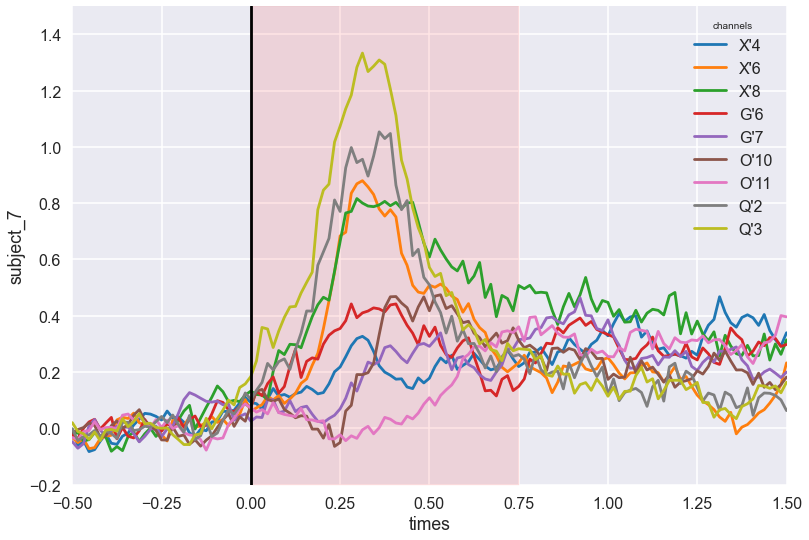

In [24]:
# load the data of a single subject
hga = load_ss(7)[0]

# plot the data of the subject
_t = hga['times'].sel(times=slice(0., 0.75)).data
hga.mean('trials').plot(x='times', hue='channels')
plt.grid(True);
plt.axvline(0., color='k');
plt.fill_between(_t, np.full((len(_t),), -.2), np.full((len(_t),), 1.5),
                 color='red', alpha=.1)
plt.xlim(-.5, 1.5), plt.ylim(-.2, 1.5);

### 1.1.2 Compute the FC

In [25]:
# select the data during the period in red
hga_poi = hga.sel(times=slice(0., .75))

# compute the functional connectivity (amplitude correlation)
conn_us = conn_dfc(hga_poi, roi='channels', times='times')

conn_us

Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=False, demeaned=False)
Computing DFC between 36 pairs (gcrn=False)


  0%|          | Estimating DFC : 0/36 [00:00<?,       ?it/s]

<xarray.DataArray 'DFC (Gaussian Copula Mutual Information Estimator)' (trials: 576, roi: 36, times: 1)>
array([[[3.67330015e-02],
        [3.54401693e-02],
        [2.97945435e-03],
        ...,
        [1.79843500e-01],
        [2.04938035e-02],
        [2.81301618e-01]],

       [[2.97951410e-05],
        [5.50963636e-03],
        [8.04907903e-02],
        ...,
        [1.08634878e-03],
        [9.21189860e-02],
        [5.55042699e-02]],

       [[4.24838662e-02],
        [1.73924580e-01],
        [8.16184655e-02],
        ...,
...
        ...,
        [9.32747796e-02],
        [1.51886627e-01],
        [5.66697240e-01]],

       [[1.69119284e-01],
        [5.16838022e-03],
        [7.86979590e-03],
        ...,
        [8.90782773e-02],
        [3.21204425e-04],
        [3.61926183e-02]],

       [[6.61421865e-02],
        [1.14019972e-03],
        [1.28024595e-03],
        ...,
        [4.17869501e-02],
        [4.85097468e-02],
        [5.09667471e-02]]])
Coordinates:
  * trials   (trials) int32 2 -2 -1 1 -1 -1 1 -2 2 ... -2 1 -1 2 2 -2 -1 -1 -1
  * roi      (roi) <U9 "X'4-X'6" "X'4-X'8" "G'6-X'4" ... "O'11-Q'3" "Q'2-Q'3"
  * times    (times) float64 0.375
Attributes:
    win_sample:  [ 0 48]
    win_times:   [0.375]
    agg_ch:      False
    type:        dfc
    estimator:   Gaussian Copula Mutual Information Estimator
    sfreq:       64.0

### 1.1.3 Connectivity array reshaping

In [26]:
conn_rsh = conn_reshape_undirected(
    conn_us.mean('trials'), 
)
conn_rsh

<xarray.DataArray 'DFC (Gaussian Copula Mutual Information Estimator)' (sources: 9, targets: 9, times: 1)>
array([[[       nan],
        [0.08077884],
        [0.07983198],
        [0.0730932 ],
        [0.07518006],
        [0.07405919],
        [0.07000016],
        [0.09055795],
        [0.0785831 ]],

       [[0.08077884],
        [       nan],
        [0.12295546],
        [0.07171076],
        [0.07595596],
        [0.06457089],
        [0.06954862],
        [0.07675924],
        [0.06835686]],

...

       [[0.09055795],
        [0.07675924],
        [0.07572576],
        [0.07664037],
        [0.07602985],
        [0.0752614 ],
        [0.07898915],
        [       nan],
        [0.09314537]],

       [[0.0785831 ],
        [0.06835686],
        [0.07511121],
        [0.06546606],
        [0.08074849],
        [0.08324631],
        [0.07226914],
        [0.09314537],
        [       nan]]])
Coordinates:
  * sources  (sources) <U4 "X'4" "G'6" "G'7" "O'10" ... "Q'2" "Q'3" "X'6" "X'8"
  * targets  (targets) <U4 "X'4" "G'6" "G'7" "O'10" ... "Q'2" "Q'3" "X'6" "X'8"
  * times    (times) float64 0.375

### 1.1.4 Plotting the connectivity array

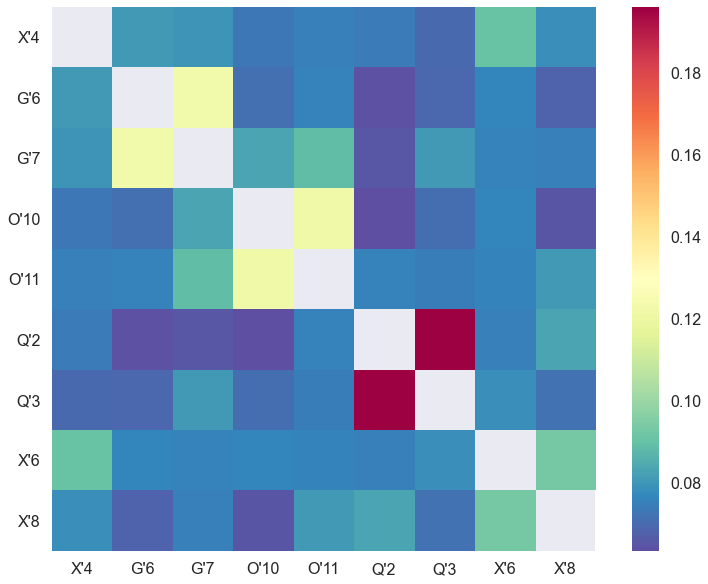

In [27]:
plot_conn(conn_us)

## 1.2 Undirected and dynamic FC
### 1.2.1 Build sliding windows

Defining temporal windows
    Definition of sliding windows (len=0.7, start=-0.5, stop=1.5, step=0.3)
    5 windows defined


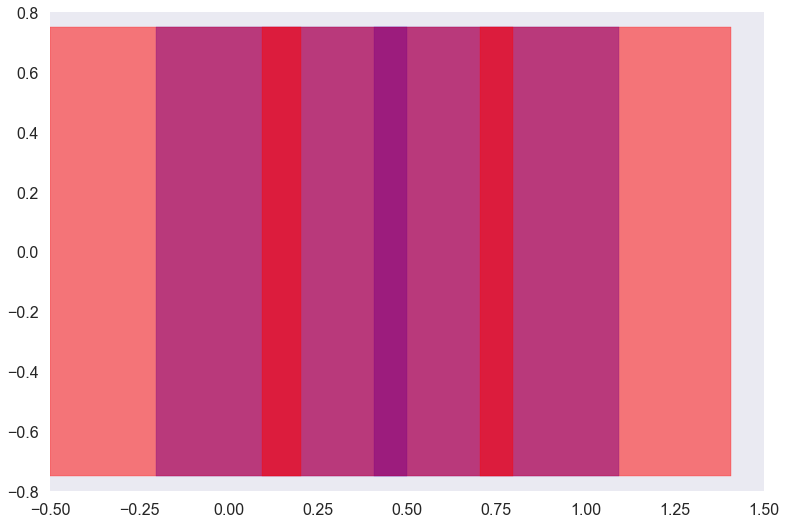

In [30]:
###############################################################################
win_len = .7   # windows of length 750ms
win_step = .3  # 400ms between each consecutive windows
###############################################################################

# get the time vector
times = hga['times'].data

# define sliding windows
win_sample, mean_time = define_windows(
    times, slwin_len=win_len, slwin_step=win_step
)

# plot the windows
plot_windows(times, win_sample)
plt.ylim(-0.8, 0.8), plt.xlim(-.5, 1.5);

In [31]:
win_sample

array([[  0,  45],
       [ 19,  64],
       [ 38,  83],
       [ 58, 102],
       [ 77, 122]])

### 1.2.2 Compute the FC inside the sliding windows

In [32]:
conn_ud = conn_dfc(hga, win_sample=win_sample, roi='channels', times='times')
conn_ud

Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=False, demeaned=False)
Computing DFC between 36 pairs (gcrn=False)


  0%|          | Estimating DFC : 0/36 [00:00<?,       ?it/s]

<xarray.DataArray 'DFC (Gaussian Copula Mutual Information Estimator)' (trials: 576, roi: 36, times: 5)>
array([[[1.46364987e-01, 1.64467007e-01, 6.49525300e-02, 1.88012972e-01,
         5.14146864e-01],
        [3.83286402e-02, 3.76075834e-01, 3.07511829e-04, 2.54455525e-02,
         4.16896865e-03],
        [2.21438357e-04, 3.33378315e-02, 2.49826093e-03, 4.00158055e-02,
         1.30216569e-01],
        ...,
        [7.88733289e-02, 1.65774040e-02, 1.74845129e-01, 3.28888208e-01,
         2.37954050e-01],
        [2.87242737e-02, 6.71520457e-02, 8.65604449e-03, 4.36300077e-02,
         3.92091237e-02],
        [7.02323139e-01, 6.09004498e-01, 1.83422267e-01, 1.60391465e-01,
         5.48255630e-02]],

       [[2.73271780e-02, 1.39693841e-01, 2.56254170e-02, 7.11443136e-03,
         3.17500889e-01],
        [2.26717554e-02, 1.86399429e-03, 2.92584882e-04, 9.50038026e-04,
         4.70402800e-02],
        [6.21007755e-03, 3.12722534e-01, 2.54036486e-02, 7.12540583e-04,
         5.41130081e-03],
...
        [4.15599227e-01, 4.02791888e-01, 5.49548399e-03, 4.26048762e-04,
         1.77861899e-01],
        [1.69544160e-01, 1.28302453e-02, 7.40143296e-05, 4.24209833e-02,
         1.68510497e-01],
        [3.84348243e-01, 8.80372003e-02, 5.42566702e-02, 2.47027904e-01,
         6.66930676e-01]],

       [[1.66448906e-01, 1.32926945e-02, 1.04149565e-01, 2.47591035e-03,
         5.66470064e-02],
        [8.89566392e-02, 8.54422688e-04, 3.05395620e-03, 1.64521694e-01,
         3.52296457e-02],
        [1.20170712e-01, 1.72857661e-02, 1.23510114e-03, 5.20860255e-02,
         4.09986190e-02],
        ...,
        [1.67081449e-02, 5.63754991e-04, 1.99557653e-05, 1.69277319e-03,
         3.54805216e-02],
        [4.00854424e-02, 4.32147160e-02, 2.05463663e-01, 2.40638643e-03,
         4.32937235e-01],
        [5.41417480e-01, 3.96447361e-01, 1.27931675e-02, 2.31271703e-02,
         1.10695593e-01]]])
Coordinates:
  * trials   (trials) int32 2 -2 -1 1 -1 -1 1 -2 2 ... -2 1 -1 2 2 -2 -1 -1 -1
  * roi      (roi) <U9 "X'4-X'6" "X'4-X'8" "G'6-X'4" ... "O'11-Q'3" "Q'2-Q'3"
  * times    (times) float64 -0.1484 0.1484 0.4453 0.75 1.055
Attributes:
    win_sample:  [  0  45  19  64  38  83  58 102  77 122]
    win_times:   [-0.1484375  0.1484375  0.4453125  0.75       1.0546875]
    agg_ch:      False
    type:        dfc
    estimator:   Gaussian Copula Mutual Information Estimator
    sfreq:       64.0

### 1.2.3 Plot the result

In [33]:
plot_conn(conn_ud, interactive=True)

interactive(children=(Dropdown(description='roi', options=("X'4-X'6", "X'4-X'8", "G'6-X'4", "G'7-X'4", "O'10-X…

### 1.2.4 Increase the resolution

In [34]:
# define sliding windows
win_sample, mean_time = define_windows(
    times, slwin_len=0.5, slwin_step=0.05
)

# compute the connectivity
conn_ud = conn_dfc(hga, win_sample=win_sample, roi='channels', times='times')

# plot the result
plot_conn(conn_ud, interactive=True)

Defining temporal windows
    Definition of sliding windows (len=0.5, start=-0.5, stop=1.5, step=0.05)
    30 windows defined
Gaussian Copula Mutual Information Estimator (mi_type=cc, copnorm=False, biascorrect=False, demeaned=False)
Computing DFC between 36 pairs (gcrn=False)


  0%|          | Estimating DFC : 0/36 [00:00<?,       ?it/s]

interactive(children=(Dropdown(description='roi', options=("X'4-X'6", "X'4-X'8", "G'6-X'4", "G'7-X'4", "O'10-X…

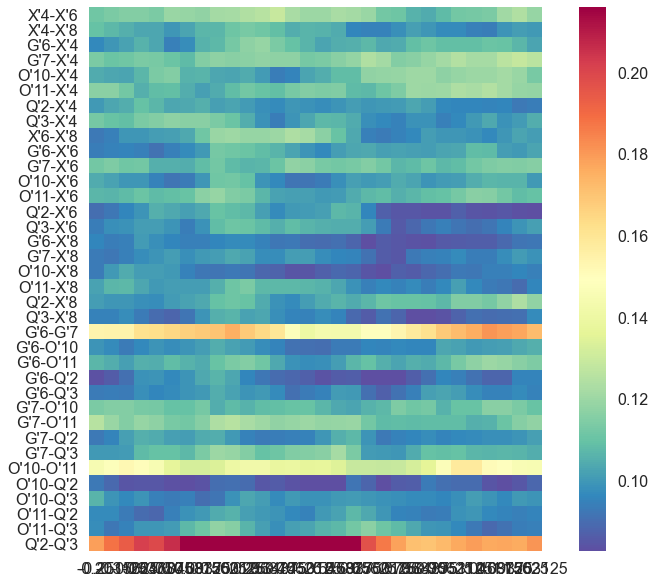

In [35]:
plot_conn(conn_ud, interactive=False)

# **2. Directed FC**
## 2.1 Directed and static FC

In [36]:
###############################################################################
dt = .75   # length 
lag = .25
t0 = 0.
###############################################################################

# load the data of a single subject
hga = load_ss(7)[0]
sfreq = hga.attrs['sfreq']

# time to sample conversion
dt_s = int(dt * sfreq)
lag_s = int(lag * sfreq)
t0_s = int(t0 * sfreq)

# compute the directed connectivity
conn_ds = conn_covgc(hga, dt_s, lag_s, t0_s, roi='channels', times='times',
                     n_jobs=-1)

WARNING | The ratio between the lag and dt is 35.41666666666667%. It's recommended to conserve this ratio less than 10-15%. Try with a step=3
Compute the  covgc (method=gc, normalised=False, n_pairs=36; n_windows=1, lag=16, dt=48, step=1)


  0%|          |  : 0/36 [00:00<?,       ?it/s]

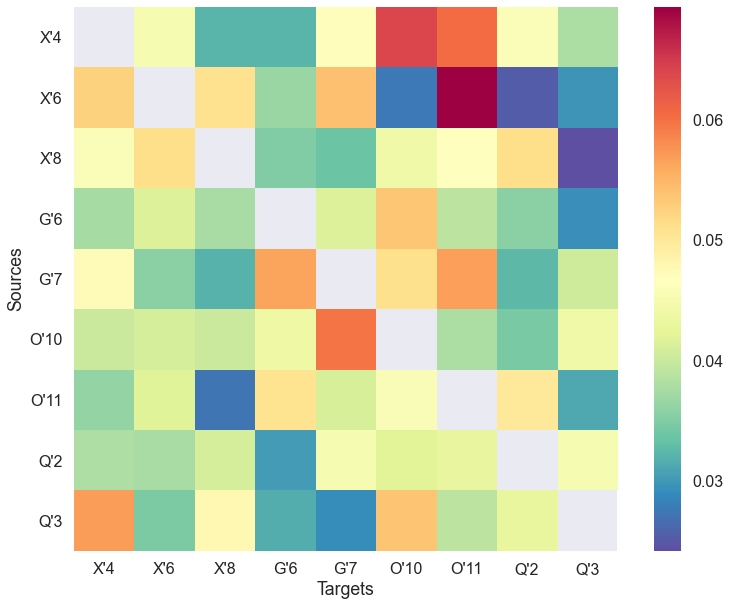

In [37]:
plot_conn(conn_ds)

## 2.1 Directed and dynamic FC _(bonus)_

<div class="alert alert-success"><p>

It's possible, but it's also computationaly very expenssive...
</p></div>

In [ ]:
# define several t0
t0_range = (np.linspace(-.25, 1., 20) * sfreq).astype(int)

# compute the dynamic for all of the t0
conn_dd = conn_covgc(hga, dt_s, lag_s, t0_range, roi='channels', times='times',
                     n_jobs=-1)

In [ ]:
plot_conn(conn_dd.copy(), interactive=True)

---
# **---- Test yourself ! ----**
## **1. Undirected FC between channels**
### 1.1 Load and prepare the data

<div class="alert alert-warning"><p>

**[Instructions]**

Load the data of subject #4. Then, define a variable `hga_s` which is going to contained the HGA of subject #4 during the **temporal period between [0, 1.5]s**
</p></div>

In [ ]:
# write your answer

### 1.2 Compute the static undirected FC

<div class="alert alert-warning"><p>

**[Instructions]**

Compute the static undirected connectivity (`conn_dfc`) on the variable `hga_s`. Save the output in a variable called `dfc`
</p></div>

In [ ]:
# write your answer

### 1.3 Plot the results

<div class="alert alert-warning"><p>

**[Instructions]**

Use the function `plot_conn` to plot the variable `dfc`. **What is the pair of contacts that are the more strongly connected?**
</p></div>

In [ ]:
# write your answer

### 1.4 Mean DFC across trials

<div class="alert alert-warning"><p>

**[Instructions]**

Take the mean of the DFC across trials and save the result in a variable called `dfc_m`
</p></div>

In [ ]:
# write your answer

### 1.5 Reshape the connectivity matrix

<div class="alert alert-warning"><p>

**[Instructions]**

Use the function `conn_reshape_undirected` on `dfc_m` to reshape the connectivity matrix (so that it becomes a 2D matrix)
</p></div>

In [ ]:
# write your answer

---
## 2. **Undirected FC between brain regions**
### 2.1 Data preparation

In the section above, we computed the connectivity between the channels of subject #4. In this section, we're going to compute the FC between **brain regions** of subject #2

<div class="alert alert-warning"><p>

**[Instructions]**

1. Load the data of subject #2 (`hga, anat, beh = load_ss(...)`)
2. Rename the dimension `channels` of the `hga` to be `roi`
3. From the `anat` output, get the list of brain regions (`list(anat['roi'])`) and fill the dimension `roi` of the variable `hga` with the name of the brain regions
</p></div>

In [ ]:
# write your answer

### 2.2 Mean HGA inside brain regions

<div class="alert alert-warning"><p>

**[Instructions]**

If you succeed in doing the previous part, your variable `hga` should now have a dimension `roi` with the name of the brain regions as a coordinate. Now, group by brain region name (`.groupby(...)`) and take the mean inside each brain region (`.mean(...)`). Save the result in a variable `hga_r`.
    
**How many brain regions the variable `hga_r` has?**
</p></div>

In [ ]:
# write your answer

### 2.3 Compute the FC between brain regions

<div class="alert alert-warning"><p>

**[Instructions]**

Comute the undirected FC (`conn_dfc`) on `hga_r` during the **temporal period [0; 1.5]s** and save the result in a variable `dfc_r`. **How many pairs of brain regions the variable `dfc_r` has?**
</p></div>

In [ ]:
# write your answer

### 2.4 Plot the results

<div class="alert alert-warning"><p>

**[Instructions]**

Use the function `plot_conn` to plot the variable `dfc_r`. **What is the pair of brain regions with the strongest connection?**
</p></div>

In [ ]:
# write your answer

### 2.5 Define sliding windows

<div class="alert alert-warning"><p>

**[Instructions]**

1. Get the time vector of the variable `hga_r` (`hga_r['times'].data`). Save the result in a variable called `times`
2. Use the function `define_windows` to define sliding windows of length 300ms (`slwin_len`) and with a step of 30ms (`slwin_step`). Save your sliding windows in a variable called `ws`
3 If you want, you can use the function `plot_windows` to plot your sliding windows
</p></div>

In [ ]:
# write your answer

### 2.6 Compute the dymanic undirected FC

<div class="alert alert-warning"><p>

**[Instructions]**

1. Now that you have your sliding windows in your variable `ws`, compute the dynamic functional connectivity on `hga_r` (`conn_dfc(..., win_sample=ws)`). Save the result in a variable called `dfc_us` 
2. Plot the result (`plot_conn(dfc_us, interactive=True)`).
    
**What is the pair of brain regions with the strongest connectivity AND at what time does it occurs?**
</p></div>

In [ ]:
# write your answer

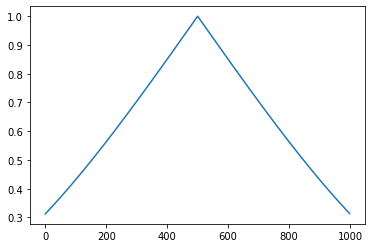

In [9]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

a = np.arange(1000)

plt.plot(signal.correlate(a, a, mode='same') / (np.sum(a ** 2)))

In [19]:
# create a vector
vector = np.random.normal(0,1,size=1000) 

# insert a signal into vector
vector[::50]+=10
ynorm = np.sum(vector**2)

# perform cross-correlation for all data points
output = np.correlate(vector,vector,mode='same') / ynorm

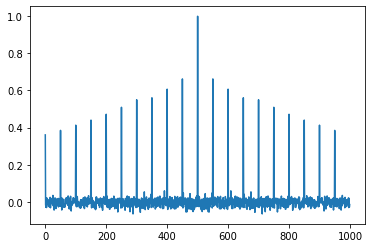

In [20]:
plt.plot(output)

In [16]:
output

array([3048.49366075])